In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import models, optimizers, layers
from tensorflow.keras.layers import Conv1D, Reshape, BatchNormalization, Activation, add, Input, MaxPooling1D, \
     Dropout, Dense, Flatten
import seaborn as sns

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# 導入資料
train = pd.read_csv("train-v3.csv")
val = pd.read_csv("valid-v3.csv")
train.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
val.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
train

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,200000,4,2.00,1900,8160,1,0,0,3,7,1900,0,1975,0,98022,47.2114,-121.986,1280,6532
1,350000,4,3.00,3380,16133,1,0,1,3,8,2330,1050,1959,0,98118,47.5501,-122.261,2500,11100
2,254000,3,2.00,2070,9000,1,0,0,4,7,1450,620,1969,0,98023,47.3085,-122.376,1630,7885
3,175000,3,1.00,1150,8924,1,0,0,3,6,1150,0,1943,0,98030,47.3865,-122.217,1492,8924
4,619000,3,2.50,2040,7503,2,0,0,3,8,2040,0,1987,0,98029,47.5718,-122.021,2170,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12962,580000,3,2.50,2200,11000,2,0,2,3,9,2200,0,1978,0,98008,47.5916,-122.112,2200,12851
12963,598000,4,2.50,3130,40918,2,0,0,3,9,3130,0,1994,0,98045,47.4761,-121.723,2760,35440
12964,252500,2,1.50,1110,986,2,0,0,3,7,950,160,2009,0,98118,47.5427,-122.272,1110,3515
12965,497000,3,2.25,1630,3817,2,0,0,3,7,1630,0,2005,0,98029,47.5485,-121.999,1630,3348


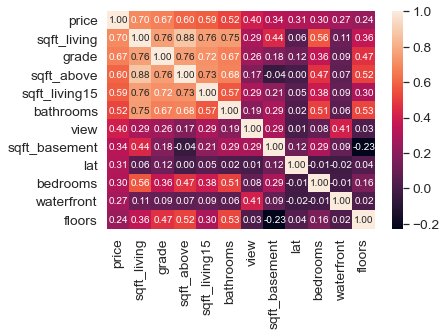

In [4]:
corrmat = train.corr()
k = 12 #number ofvariables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, 
yticklabels=cols.values, xticklabels=cols.values)
plt.show()

C:\Users\USER\anaconda3\envs\rtx3070\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


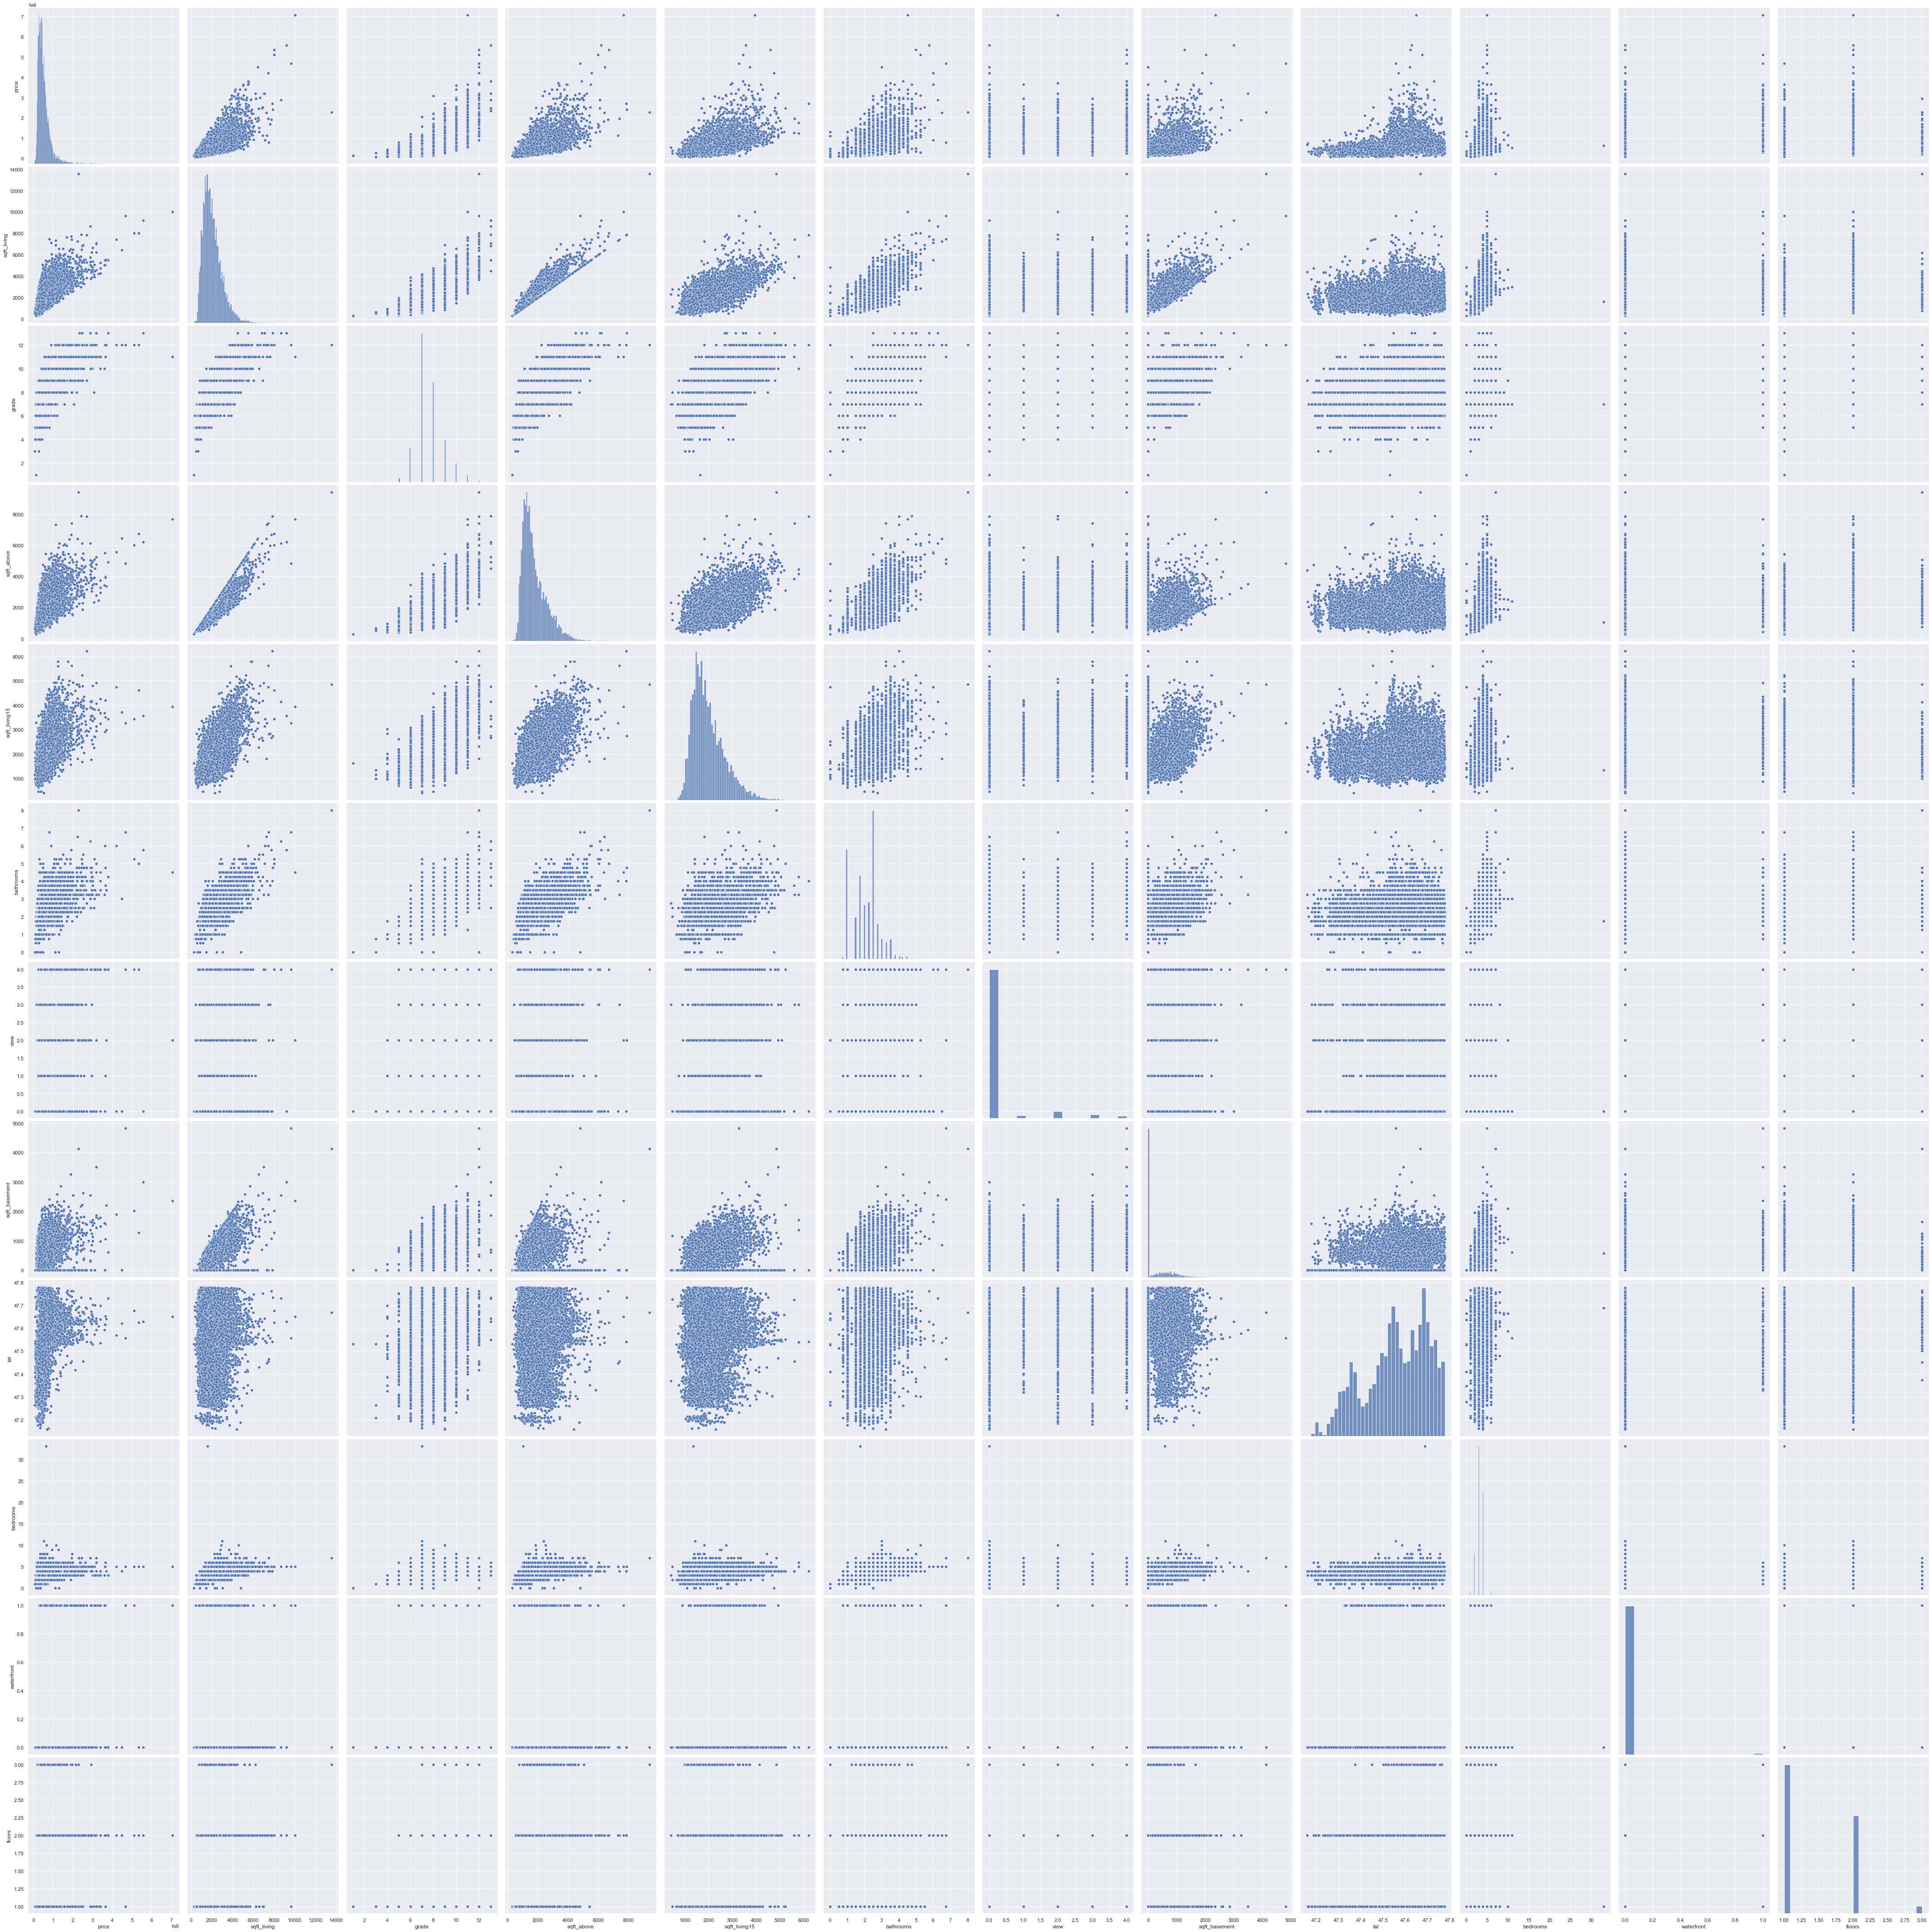

In [5]:
sns.set()
sns.pairplot(train[cols], size = 5)
plt.show();

In [6]:
del_cols = [i for i in list(train.columns) if i not in list(cols)]
del_cols

['sqft_lot',
 'condition',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'long',
 'sqft_lot15']

In [7]:
train = train.drop(del_cols, axis='columns')
val = val.drop(del_cols, axis='columns')

In [8]:
# mean = train.mean()
# std = train.std()
# #挑出信賴區間的資料
# for i in cols:
#     condition = train[i] <= mean[i] + 3 * std[i]
#     train = train[condition]
# for i in cols:
#     condition = mean[i] - 3 * std[i] <= train[i]
#     train = train[condition]
# train = train.reset_index(drop=True)
# train.shape

In [9]:
#找出缺失數據
total= train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
sqft_living15,0,0.0
lat,0,0.0
sqft_basement,0,0.0
sqft_above,0,0.0
grade,0,0.0
view,0,0.0
waterfront,0,0.0
floors,0,0.0
sqft_living,0,0.0
bathrooms,0,0.0


In [10]:
# from sklearn.preprocessing import StandardScaler
# saleprice_scaled= StandardScaler().fit_transform(train['price'][:,np.newaxis]);
# low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:100]
# high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-100:]

# index_low = [i for i in range(saleprice_scaled.shape[0]) if saleprice_scaled[i] in low_range]
# index_high = [i for i in range(saleprice_scaled.shape[0]) if saleprice_scaled[i] in high_range]

# train = train.drop(index_low)
# train = train.drop(index_high)
# train = train.reset_index(drop=True)
# train.shape

In [11]:
x_train = train.drop('price', axis='columns')
y_train = train['price']
x_val = val.drop('price', axis='columns')
y_val = val['price']
x_train.shape

(12967, 11)

In [12]:
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std

In [13]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
# 建構模型
inputs = Input(shape=(x_train.shape[1],), name='inputs')
layer1 = layers.Dense(64, activation='relu')(inputs)
# layer1 = layers.Dropout(0.1)(layer1)

layer2 = layers.Dense(128, activation='relu')(layer1)
# layer2 = layers.Dropout(0.1)(layer2)

layer3 = layers.Dense(512, activation='relu')(layer2)
# layer3 = layers.Dropout(0.5)(layer3)

layer4 = layers.Dense(128, activation='relu')(layer3)
# layer4 = layers.Dropout(0.2)(layer4)

layer5 = layers.Dense(64, activation='relu')(layer4)
# layer5 = layers.Dropout(0.3)(layer5)

# layer6 = layers.Dense(32,activation='relu')(layer5)
# layer6 = layers.Dropout(0.3)(layer6)

# layer7 = layers.Dense(32,kernel_regularizer=keras.regularizers.l2(0.00001), activation='relu')(layer6)
# layer7 = layers.Dropout(0.3)(layer7)

outputs = layers.Dense(1, activation='linear')(layer5)
HW01 = keras.Model(inputs, outputs)
HW01.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65    

In [15]:
# 查看模型
HW01.compile(optimizer=optimizers.Adam(lr=0.0001),
                  loss='mean_absolute_error',
               metrics=['mae'])
history = HW01.fit(x_train, y_train, 
               batch_size=64,  
               epochs=1500,  
               validation_data=(x_val, y_val))

Epoch 1/1500
203/203 [==============================] - 2s 4ms/step - loss: 548130.0594 - mae: 548130.0594 - val_loss: 528792.5625 - val_mae: 528792.5625
Epoch 2/1500
203/203 [==============================] - 1s 3ms/step - loss: 534941.8344 - mae: 534941.8344 - val_loss: 490986.4688 - val_mae: 490986.4688
Epoch 3/1500
203/203 [==============================] - 1s 3ms/step - loss: 453152.0101 - mae: 453152.0101 - val_loss: 243569.8906 - val_mae: 243569.8906
Epoch 4/1500
203/203 [==============================] - 1s 3ms/step - loss: 212751.4726 - mae: 212751.4726 - val_loss: 171687.2344 - val_mae: 171687.2344
Epoch 5/1500
203/203 [==============================] - 1s 3ms/step - loss: 173688.6218 - mae: 173688.6218 - val_loss: 160127.9375 - val_mae: 160127.9375
Epoch 6/1500
203/203 [==============================] - 1s 3ms/step - loss: 165985.5361 - mae: 165985.5361 - val_loss: 153268.9688 - val_mae: 153268.9688
Epoch 7/1500
203/203 [==============================] - 1s 3ms/step - loss: 

Epoch 54/1500
203/203 [==============================] - 1s 3ms/step - loss: 120318.9891 - mae: 120318.9891 - val_loss: 115696.8516 - val_mae: 115696.8516
Epoch 55/1500
203/203 [==============================] - 1s 3ms/step - loss: 119369.3987 - mae: 119369.3987 - val_loss: 115641.3750 - val_mae: 115641.3750
Epoch 56/1500
203/203 [==============================] - 1s 3ms/step - loss: 118495.9190 - mae: 118495.9190 - val_loss: 115418.4219 - val_mae: 115418.4219
Epoch 57/1500
203/203 [==============================] - 1s 3ms/step - loss: 117815.4371 - mae: 117815.4371 - val_loss: 115143.3516 - val_mae: 115143.3516
Epoch 58/1500
203/203 [==============================] - 1s 3ms/step - loss: 119261.8448 - mae: 119261.8448 - val_loss: 115000.4531 - val_mae: 115000.4531
Epoch 59/1500
203/203 [==============================] - 1s 3ms/step - loss: 118781.9707 - mae: 118781.9707 - val_loss: 114774.8594 - val_mae: 114774.8594
Epoch 60/1500
203/203 [==============================] - 1s 3ms/step -

Epoch 107/1500
203/203 [==============================] - 1s 3ms/step - loss: 107250.0508 - mae: 107250.0508 - val_loss: 104918.2266 - val_mae: 104918.2266
Epoch 108/1500
203/203 [==============================] - 1s 3ms/step - loss: 107228.0866 - mae: 107228.0866 - val_loss: 104658.0625 - val_mae: 104658.0625
Epoch 109/1500
203/203 [==============================] - 1s 3ms/step - loss: 109834.2339 - mae: 109834.2339 - val_loss: 104469.6328 - val_mae: 104469.6328
Epoch 110/1500
203/203 [==============================] - 1s 3ms/step - loss: 105876.8233 - mae: 105876.8233 - val_loss: 104259.3906 - val_mae: 104259.3906
Epoch 111/1500
203/203 [==============================] - 1s 3ms/step - loss: 105704.1453 - mae: 105704.1453 - val_loss: 104077.6797 - val_mae: 104077.6797
Epoch 112/1500
203/203 [==============================] - 1s 3ms/step - loss: 105289.1287 - mae: 105289.1287 - val_loss: 103819.1172 - val_mae: 103819.1172
Epoch 113/1500
203/203 [==============================] - 1s 3ms

203/203 [==============================] - 1s 3ms/step - loss: 96656.9999 - mae: 96656.9999 - val_loss: 92686.5703 - val_mae: 92686.5703
Epoch 161/1500
203/203 [==============================] - 1s 3ms/step - loss: 96031.2153 - mae: 96031.2153 - val_loss: 92320.7891 - val_mae: 92320.7891
Epoch 162/1500
203/203 [==============================] - 1s 3ms/step - loss: 97254.6597 - mae: 97254.6597 - val_loss: 92207.3516 - val_mae: 92207.3516
Epoch 163/1500
203/203 [==============================] - 1s 3ms/step - loss: 95703.9053 - mae: 95703.9053 - val_loss: 92076.0547 - val_mae: 92076.0547
Epoch 164/1500
203/203 [==============================] - 1s 3ms/step - loss: 93002.7846 - mae: 93002.7846 - val_loss: 91783.5781 - val_mae: 91783.5781
Epoch 165/1500
203/203 [==============================] - 1s 3ms/step - loss: 93878.3059 - mae: 93878.3059 - val_loss: 91702.0000 - val_mae: 91702.0000
Epoch 166/1500
203/203 [==============================] - 1s 3ms/step - loss: 95415.1811 - mae: 95415.1

Epoch 214/1500
203/203 [==============================] - 1s 3ms/step - loss: 92242.9543 - mae: 92242.9543 - val_loss: 88035.3516 - val_mae: 88035.3516
Epoch 215/1500
203/203 [==============================] - 1s 3ms/step - loss: 91619.7827 - mae: 91619.7827 - val_loss: 87961.4375 - val_mae: 87961.4375
Epoch 216/1500
203/203 [==============================] - 1s 3ms/step - loss: 90771.5058 - mae: 90771.5058 - val_loss: 88088.4219 - val_mae: 88088.4219
Epoch 217/1500
203/203 [==============================] - 1s 3ms/step - loss: 90833.7700 - mae: 90833.7700 - val_loss: 87929.3594 - val_mae: 87929.3594
Epoch 218/1500
203/203 [==============================] - 1s 3ms/step - loss: 92146.5676 - mae: 92146.5676 - val_loss: 87931.7891 - val_mae: 87931.7891
Epoch 219/1500
203/203 [==============================] - 1s 3ms/step - loss: 91396.0590 - mae: 91396.0590 - val_loss: 87774.1641 - val_mae: 87774.1641
Epoch 220/1500
203/203 [==============================] - 1s 3ms/step - loss: 90874.4280

Epoch 268/1500
203/203 [==============================] - 1s 3ms/step - loss: 90784.4843 - mae: 90784.4843 - val_loss: 86578.0156 - val_mae: 86578.0156
Epoch 269/1500
203/203 [==============================] - 1s 3ms/step - loss: 90443.1248 - mae: 90443.1248 - val_loss: 86658.1875 - val_mae: 86658.1875
Epoch 270/1500
203/203 [==============================] - 1s 3ms/step - loss: 89486.8600 - mae: 89486.8600 - val_loss: 86519.6172 - val_mae: 86519.6172
Epoch 271/1500
203/203 [==============================] - 1s 3ms/step - loss: 90822.3361 - mae: 90822.3361 - val_loss: 86410.0000 - val_mae: 86410.0000
Epoch 272/1500
203/203 [==============================] - 1s 3ms/step - loss: 90598.3533 - mae: 90598.3533 - val_loss: 86505.6953 - val_mae: 86505.6953
Epoch 273/1500
203/203 [==============================] - 1s 3ms/step - loss: 91768.7855 - mae: 91768.7855 - val_loss: 86403.5625 - val_mae: 86403.5625
Epoch 274/1500
203/203 [==============================] - 1s 3ms/step - loss: 89981.0178

Epoch 322/1500
203/203 [==============================] - 1s 3ms/step - loss: 89136.7792 - mae: 89136.7792 - val_loss: 85766.2734 - val_mae: 85766.2734
Epoch 323/1500
203/203 [==============================] - 1s 3ms/step - loss: 90072.8887 - mae: 90072.8887 - val_loss: 85892.2500 - val_mae: 85892.2500
Epoch 324/1500
203/203 [==============================] - 1s 4ms/step - loss: 89545.1580 - mae: 89545.1580 - val_loss: 85829.6094 - val_mae: 85829.6094
Epoch 325/1500
203/203 [==============================] - 1s 3ms/step - loss: 89079.6904 - mae: 89079.6904 - val_loss: 85882.0703 - val_mae: 85882.0703
Epoch 326/1500
203/203 [==============================] - 1s 3ms/step - loss: 89958.0624 - mae: 89958.0624 - val_loss: 85789.8984 - val_mae: 85789.8984
Epoch 327/1500
203/203 [==============================] - 1s 3ms/step - loss: 88908.5867 - mae: 88908.5867 - val_loss: 85784.2891 - val_mae: 85784.2891
Epoch 328/1500
203/203 [==============================] - 1s 3ms/step - loss: 89123.7326

Epoch 376/1500
203/203 [==============================] - 1s 3ms/step - loss: 89131.3302 - mae: 89131.3302 - val_loss: 85405.4844 - val_mae: 85405.4844
Epoch 377/1500
203/203 [==============================] - 1s 3ms/step - loss: 89312.3132 - mae: 89312.3132 - val_loss: 85441.1016 - val_mae: 85441.1016
Epoch 378/1500
203/203 [==============================] - 1s 3ms/step - loss: 88700.8830 - mae: 88700.8830 - val_loss: 85481.4922 - val_mae: 85481.4922
Epoch 379/1500
203/203 [==============================] - 1s 3ms/step - loss: 89297.9373 - mae: 89297.9373 - val_loss: 85547.2734 - val_mae: 85547.2734
Epoch 380/1500
203/203 [==============================] - 1s 3ms/step - loss: 90370.6065 - mae: 90370.6065 - val_loss: 85479.1797 - val_mae: 85479.1797
Epoch 381/1500
203/203 [==============================] - 1s 3ms/step - loss: 89143.5455 - mae: 89143.5455 - val_loss: 85440.5078 - val_mae: 85440.5078
Epoch 382/1500
203/203 [==============================] - 1s 3ms/step - loss: 89974.3097

Epoch 430/1500
203/203 [==============================] - 1s 3ms/step - loss: 88785.8164 - mae: 88785.8164 - val_loss: 85188.7656 - val_mae: 85188.7656
Epoch 431/1500
203/203 [==============================] - 1s 3ms/step - loss: 86142.3961 - mae: 86142.3961 - val_loss: 85236.4141 - val_mae: 85236.4141
Epoch 432/1500
203/203 [==============================] - 1s 3ms/step - loss: 87536.5388 - mae: 87536.5388 - val_loss: 85230.3906 - val_mae: 85230.3906
Epoch 433/1500
203/203 [==============================] - 1s 3ms/step - loss: 87510.6357 - mae: 87510.6357 - val_loss: 85254.9844 - val_mae: 85254.9844
Epoch 434/1500
203/203 [==============================] - 1s 3ms/step - loss: 87949.1892 - mae: 87949.1892 - val_loss: 85566.0469 - val_mae: 85566.0469
Epoch 435/1500
203/203 [==============================] - 1s 3ms/step - loss: 88767.6688 - mae: 88767.6688 - val_loss: 85374.7031 - val_mae: 85374.7031
Epoch 436/1500
203/203 [==============================] - 1s 3ms/step - loss: 87855.5892

Epoch 484/1500
203/203 [==============================] - 1s 3ms/step - loss: 89269.9176 - mae: 89269.9176 - val_loss: 85158.4766 - val_mae: 85158.4766
Epoch 485/1500
203/203 [==============================] - 1s 3ms/step - loss: 87322.3163 - mae: 87322.3163 - val_loss: 85179.5391 - val_mae: 85179.5391
Epoch 486/1500
203/203 [==============================] - 1s 3ms/step - loss: 87926.5081 - mae: 87926.5081 - val_loss: 85169.5469 - val_mae: 85169.5469
Epoch 487/1500
203/203 [==============================] - 1s 3ms/step - loss: 89227.1678 - mae: 89227.1678 - val_loss: 85143.8281 - val_mae: 85143.8281
Epoch 488/1500
203/203 [==============================] - 1s 3ms/step - loss: 87553.1396 - mae: 87553.1396 - val_loss: 85087.8047 - val_mae: 85087.8047
Epoch 489/1500
203/203 [==============================] - 1s 3ms/step - loss: 88248.5889 - mae: 88248.5889 - val_loss: 85060.8828 - val_mae: 85060.8828
Epoch 490/1500
203/203 [==============================] - 1s 3ms/step - loss: 86200.3316

Epoch 538/1500
203/203 [==============================] - 1s 3ms/step - loss: 87217.7078 - mae: 87217.7078 - val_loss: 84778.3516 - val_mae: 84778.3516
Epoch 539/1500
203/203 [==============================] - 1s 3ms/step - loss: 87564.8730 - mae: 87564.8730 - val_loss: 84849.2031 - val_mae: 84849.2031
Epoch 540/1500
203/203 [==============================] - 1s 3ms/step - loss: 87004.9435 - mae: 87004.9435 - val_loss: 84947.3906 - val_mae: 84947.3906
Epoch 541/1500
203/203 [==============================] - 1s 3ms/step - loss: 85353.6244 - mae: 85353.6244 - val_loss: 84808.4688 - val_mae: 84808.4688
Epoch 542/1500
203/203 [==============================] - 1s 3ms/step - loss: 88576.7871 - mae: 88576.7871 - val_loss: 84855.2344 - val_mae: 84855.2344
Epoch 543/1500
203/203 [==============================] - 1s 3ms/step - loss: 86706.2988 - mae: 86706.2988 - val_loss: 84837.5312 - val_mae: 84837.5312
Epoch 544/1500
203/203 [==============================] - 1s 3ms/step - loss: 85710.4373

Epoch 592/1500
203/203 [==============================] - 1s 3ms/step - loss: 83883.0503 - mae: 83883.0503 - val_loss: 84800.9453 - val_mae: 84800.9453
Epoch 593/1500
203/203 [==============================] - 1s 3ms/step - loss: 89297.1275 - mae: 89297.1275 - val_loss: 85073.8281 - val_mae: 85073.8281
Epoch 594/1500
203/203 [==============================] - 1s 3ms/step - loss: 87028.6794 - mae: 87028.6794 - val_loss: 84714.1875 - val_mae: 84714.1875
Epoch 595/1500
203/203 [==============================] - 1s 3ms/step - loss: 87642.7859 - mae: 87642.7859 - val_loss: 84662.9297 - val_mae: 84662.9297
Epoch 596/1500
203/203 [==============================] - 1s 3ms/step - loss: 85759.3501 - mae: 85759.3501 - val_loss: 84696.2422 - val_mae: 84696.2422
Epoch 597/1500
203/203 [==============================] - 1s 3ms/step - loss: 88223.3362 - mae: 88223.3362 - val_loss: 84840.9531 - val_mae: 84840.9531
Epoch 598/1500
203/203 [==============================] - 1s 3ms/step - loss: 85660.7450

Epoch 646/1500
203/203 [==============================] - 1s 3ms/step - loss: 87405.9860 - mae: 87405.9860 - val_loss: 84685.8984 - val_mae: 84685.8984
Epoch 647/1500
203/203 [==============================] - 1s 3ms/step - loss: 85049.9018 - mae: 85049.9018 - val_loss: 84608.6875 - val_mae: 84608.6875
Epoch 648/1500
203/203 [==============================] - 1s 3ms/step - loss: 84775.9681 - mae: 84775.9681 - val_loss: 84441.6953 - val_mae: 84441.6953
Epoch 649/1500
203/203 [==============================] - 1s 3ms/step - loss: 86776.9334 - mae: 86776.9334 - val_loss: 84534.0703 - val_mae: 84534.0703
Epoch 650/1500
203/203 [==============================] - 1s 3ms/step - loss: 84817.8796 - mae: 84817.8796 - val_loss: 84498.6797 - val_mae: 84498.6797
Epoch 651/1500
203/203 [==============================] - 1s 3ms/step - loss: 87259.0007 - mae: 87259.0007 - val_loss: 84599.5391 - val_mae: 84599.5391
Epoch 652/1500
203/203 [==============================] - 1s 3ms/step - loss: 86022.5071

Epoch 700/1500
203/203 [==============================] - 1s 3ms/step - loss: 83491.2267 - mae: 83491.2267 - val_loss: 84649.1797 - val_mae: 84649.1797
Epoch 701/1500
203/203 [==============================] - 1s 3ms/step - loss: 84084.3569 - mae: 84084.3569 - val_loss: 84689.0312 - val_mae: 84689.0312
Epoch 702/1500
203/203 [==============================] - 1s 3ms/step - loss: 88435.6645 - mae: 88435.6645 - val_loss: 84838.3984 - val_mae: 84838.3984
Epoch 703/1500
203/203 [==============================] - 1s 4ms/step - loss: 86573.9831 - mae: 86573.9831 - val_loss: 84554.4062 - val_mae: 84554.4062
Epoch 704/1500
203/203 [==============================] - 1s 3ms/step - loss: 86463.4946 - mae: 86463.4946 - val_loss: 84700.4609 - val_mae: 84700.4609
Epoch 705/1500
203/203 [==============================] - 1s 3ms/step - loss: 83378.8274 - mae: 83378.8274 - val_loss: 84720.0703 - val_mae: 84720.0703
Epoch 706/1500
203/203 [==============================] - 1s 3ms/step - loss: 84090.3401

Epoch 754/1500
203/203 [==============================] - 1s 3ms/step - loss: 85108.2710 - mae: 85108.2710 - val_loss: 84517.9297 - val_mae: 84517.9297
Epoch 755/1500
203/203 [==============================] - 1s 3ms/step - loss: 86072.8551 - mae: 86072.8551 - val_loss: 84703.2578 - val_mae: 84703.2578
Epoch 756/1500
203/203 [==============================] - 1s 3ms/step - loss: 85230.5774 - mae: 85230.5774 - val_loss: 84561.5703 - val_mae: 84561.5703
Epoch 757/1500
203/203 [==============================] - 1s 3ms/step - loss: 85285.7495 - mae: 85285.7495 - val_loss: 84523.8203 - val_mae: 84523.8203
Epoch 758/1500
203/203 [==============================] - 1s 3ms/step - loss: 85049.4206 - mae: 85049.4206 - val_loss: 84561.0859 - val_mae: 84561.0859
Epoch 759/1500
203/203 [==============================] - 1s 3ms/step - loss: 84357.0615 - mae: 84357.0615 - val_loss: 84558.6016 - val_mae: 84558.6016
Epoch 760/1500
203/203 [==============================] - 1s 3ms/step - loss: 85370.5592

Epoch 808/1500
203/203 [==============================] - 1s 4ms/step - loss: 84911.7744 - mae: 84911.7744 - val_loss: 84479.8672 - val_mae: 84479.8672
Epoch 809/1500
203/203 [==============================] - 1s 3ms/step - loss: 84163.3375 - mae: 84163.3375 - val_loss: 84728.6719 - val_mae: 84728.6719
Epoch 810/1500
203/203 [==============================] - 1s 3ms/step - loss: 84228.4500 - mae: 84228.4500 - val_loss: 84589.8125 - val_mae: 84589.8125
Epoch 811/1500
203/203 [==============================] - 1s 3ms/step - loss: 84864.5387 - mae: 84864.5387 - val_loss: 84511.4141 - val_mae: 84511.4141
Epoch 812/1500
203/203 [==============================] - 1s 4ms/step - loss: 85610.6272 - mae: 85610.6272 - val_loss: 84431.5781 - val_mae: 84431.5781
Epoch 813/1500
203/203 [==============================] - 1s 3ms/step - loss: 83585.7484 - mae: 83585.7484 - val_loss: 84362.9297 - val_mae: 84362.9297
Epoch 814/1500
203/203 [==============================] - 1s 4ms/step - loss: 82548.1074

Epoch 862/1500
203/203 [==============================] - 1s 3ms/step - loss: 84279.3681 - mae: 84279.3681 - val_loss: 84506.3672 - val_mae: 84506.3672
Epoch 863/1500
203/203 [==============================] - 1s 3ms/step - loss: 84910.5877 - mae: 84910.5877 - val_loss: 84537.8984 - val_mae: 84537.8984
Epoch 864/1500
203/203 [==============================] - 1s 3ms/step - loss: 84266.4780 - mae: 84266.4780 - val_loss: 84571.9219 - val_mae: 84571.9219
Epoch 865/1500
203/203 [==============================] - 1s 3ms/step - loss: 85132.8150 - mae: 85132.8150 - val_loss: 84453.1172 - val_mae: 84453.1172
Epoch 866/1500
203/203 [==============================] - 1s 3ms/step - loss: 83418.6786 - mae: 83418.6786 - val_loss: 84572.6719 - val_mae: 84572.6719
Epoch 867/1500
203/203 [==============================] - 1s 3ms/step - loss: 82850.0654 - mae: 82850.0654 - val_loss: 84512.3906 - val_mae: 84512.3906
Epoch 868/1500
203/203 [==============================] - 1s 3ms/step - loss: 84205.8672

Epoch 916/1500
203/203 [==============================] - 1s 3ms/step - loss: 83564.9218 - mae: 83564.9218 - val_loss: 84725.9609 - val_mae: 84725.9609
Epoch 917/1500
203/203 [==============================] - 1s 3ms/step - loss: 83083.5659 - mae: 83083.5659 - val_loss: 84573.1250 - val_mae: 84573.1250
Epoch 918/1500
203/203 [==============================] - 1s 3ms/step - loss: 85544.1194 - mae: 85544.1194 - val_loss: 84521.1562 - val_mae: 84521.1562
Epoch 919/1500
203/203 [==============================] - 1s 3ms/step - loss: 83925.4339 - mae: 83925.4339 - val_loss: 84548.9766 - val_mae: 84548.9766
Epoch 920/1500
203/203 [==============================] - 1s 3ms/step - loss: 83620.1742 - mae: 83620.1742 - val_loss: 84650.6797 - val_mae: 84650.6797
Epoch 921/1500
203/203 [==============================] - 1s 3ms/step - loss: 84276.1924 - mae: 84276.1924 - val_loss: 84563.6016 - val_mae: 84563.6016
Epoch 922/1500
203/203 [==============================] - 1s 3ms/step - loss: 84034.7313

Epoch 970/1500
203/203 [==============================] - 1s 4ms/step - loss: 84227.8706 - mae: 84227.8706 - val_loss: 84589.7969 - val_mae: 84589.7891
Epoch 971/1500
203/203 [==============================] - 1s 4ms/step - loss: 85119.1463 - mae: 85119.1463 - val_loss: 84359.9062 - val_mae: 84359.9062
Epoch 972/1500
203/203 [==============================] - 1s 4ms/step - loss: 83310.5061 - mae: 83310.5061 - val_loss: 84372.7422 - val_mae: 84372.7422
Epoch 973/1500
203/203 [==============================] - 1s 3ms/step - loss: 84322.4577 - mae: 84322.4577 - val_loss: 84531.3203 - val_mae: 84531.3203
Epoch 974/1500
203/203 [==============================] - 1s 4ms/step - loss: 82717.5880 - mae: 82717.5880 - val_loss: 84353.7734 - val_mae: 84353.7734
Epoch 975/1500
203/203 [==============================] - 1s 4ms/step - loss: 82800.6766 - mae: 82800.6766 - val_loss: 84424.0078 - val_mae: 84424.0078
Epoch 976/1500
203/203 [==============================] - 1s 4ms/step - loss: 83314.8653

203/203 [==============================] - 1s 4ms/step - loss: 85259.2069 - mae: 85259.2069 - val_loss: 84347.8359 - val_mae: 84347.8359
Epoch 1024/1500
203/203 [==============================] - 1s 4ms/step - loss: 83596.4720 - mae: 83596.4720 - val_loss: 84833.6797 - val_mae: 84833.6797
Epoch 1025/1500
203/203 [==============================] - 1s 4ms/step - loss: 82521.2920 - mae: 82521.2920 - val_loss: 84362.9922 - val_mae: 84362.9922
Epoch 1026/1500
203/203 [==============================] - 1s 4ms/step - loss: 82776.5682 - mae: 82776.5682 - val_loss: 84643.4219 - val_mae: 84643.4219
Epoch 1027/1500
203/203 [==============================] - 1s 4ms/step - loss: 85507.9751 - mae: 85507.9751 - val_loss: 84087.3125 - val_mae: 84087.3125
Epoch 1028/1500
203/203 [==============================] - 1s 4ms/step - loss: 84467.7580 - mae: 84467.7580 - val_loss: 84277.3984 - val_mae: 84277.3984
Epoch 1029/1500
203/203 [==============================] - 1s 4ms/step - loss: 83960.3846 - mae: 8

203/203 [==============================] - 1s 3ms/step - loss: 83858.7118 - mae: 83858.7118 - val_loss: 84297.8359 - val_mae: 84297.8359
Epoch 1077/1500
203/203 [==============================] - 1s 3ms/step - loss: 82459.4602 - mae: 82459.4602 - val_loss: 84059.2031 - val_mae: 84059.2031
Epoch 1078/1500
203/203 [==============================] - 1s 3ms/step - loss: 82971.8627 - mae: 82971.8627 - val_loss: 84203.5859 - val_mae: 84203.5859
Epoch 1079/1500
203/203 [==============================] - 1s 3ms/step - loss: 81337.5976 - mae: 81337.5976 - val_loss: 84959.1406 - val_mae: 84959.1406
Epoch 1080/1500
203/203 [==============================] - 1s 3ms/step - loss: 82709.4843 - mae: 82709.4843 - val_loss: 84294.0938 - val_mae: 84294.0938
Epoch 1081/1500
203/203 [==============================] - 1s 3ms/step - loss: 84315.5784 - mae: 84315.5784 - val_loss: 84359.2812 - val_mae: 84359.2812
Epoch 1082/1500
203/203 [==============================] - 1s 4ms/step - loss: 83521.1757 - mae: 8

203/203 [==============================] - 1s 3ms/step - loss: 82305.0879 - mae: 82305.0879 - val_loss: 84251.7031 - val_mae: 84251.7031
Epoch 1130/1500
203/203 [==============================] - 1s 3ms/step - loss: 84668.7572 - mae: 84668.7572 - val_loss: 84117.5391 - val_mae: 84117.5391
Epoch 1131/1500
203/203 [==============================] - 1s 3ms/step - loss: 84757.7513 - mae: 84757.7513 - val_loss: 84107.4609 - val_mae: 84107.4609
Epoch 1132/1500
203/203 [==============================] - 1s 3ms/step - loss: 83448.8948 - mae: 83448.8948 - val_loss: 84083.5547 - val_mae: 84083.5547
Epoch 1133/1500
203/203 [==============================] - 1s 3ms/step - loss: 81868.6156 - mae: 81868.6156 - val_loss: 84025.4688 - val_mae: 84025.4688
Epoch 1134/1500
203/203 [==============================] - 1s 3ms/step - loss: 81152.5091 - mae: 81152.5091 - val_loss: 84026.1484 - val_mae: 84026.1484
Epoch 1135/1500
203/203 [==============================] - 1s 3ms/step - loss: 82353.8622 - mae: 8

203/203 [==============================] - 1s 4ms/step - loss: 82995.5147 - mae: 82995.5147 - val_loss: 84199.4062 - val_mae: 84199.4062
Epoch 1183/1500
203/203 [==============================] - 1s 4ms/step - loss: 85178.9840 - mae: 85178.9840 - val_loss: 83910.6172 - val_mae: 83910.6172
Epoch 1184/1500
203/203 [==============================] - 1s 4ms/step - loss: 82793.1373 - mae: 82793.1373 - val_loss: 84002.9062 - val_mae: 84002.9062
Epoch 1185/1500
203/203 [==============================] - 1s 4ms/step - loss: 80067.7467 - mae: 80067.7467 - val_loss: 84002.8125 - val_mae: 84002.8125
Epoch 1186/1500
203/203 [==============================] - 1s 3ms/step - loss: 81810.2038 - mae: 81810.2038 - val_loss: 83864.1406 - val_mae: 83864.1406
Epoch 1187/1500
203/203 [==============================] - 1s 3ms/step - loss: 82177.0844 - mae: 82177.0844 - val_loss: 83770.7188 - val_mae: 83770.7188
Epoch 1188/1500
203/203 [==============================] - 1s 3ms/step - loss: 82132.3014 - mae: 8

203/203 [==============================] - 1s 4ms/step - loss: 81746.3596 - mae: 81746.3596 - val_loss: 84024.3594 - val_mae: 84024.3594
Epoch 1236/1500
203/203 [==============================] - 1s 3ms/step - loss: 80989.3074 - mae: 80989.3074 - val_loss: 84115.4297 - val_mae: 84115.4297
Epoch 1237/1500
203/203 [==============================] - 1s 4ms/step - loss: 81216.9316 - mae: 81216.9316 - val_loss: 84102.4219 - val_mae: 84102.4219
Epoch 1238/1500
203/203 [==============================] - 1s 3ms/step - loss: 80119.9559 - mae: 80119.9559 - val_loss: 84169.9844 - val_mae: 84169.9844
Epoch 1239/1500
203/203 [==============================] - 1s 4ms/step - loss: 82718.0731 - mae: 82718.0731 - val_loss: 83815.3359 - val_mae: 83815.3438
Epoch 1240/1500
203/203 [==============================] - 1s 3ms/step - loss: 83614.7774 - mae: 83614.7774 - val_loss: 83751.5703 - val_mae: 83751.5703
Epoch 1241/1500
203/203 [==============================] - 1s 4ms/step - loss: 81178.0555 - mae: 8

203/203 [==============================] - 1s 4ms/step - loss: 81800.4748 - mae: 81800.4748 - val_loss: 83821.3906 - val_mae: 83821.3906
Epoch 1289/1500
203/203 [==============================] - 1s 4ms/step - loss: 81630.7483 - mae: 81630.7483 - val_loss: 84066.9297 - val_mae: 84066.9297
Epoch 1290/1500
203/203 [==============================] - 1s 4ms/step - loss: 81189.0922 - mae: 81189.0922 - val_loss: 84332.8125 - val_mae: 84332.8125
Epoch 1291/1500
203/203 [==============================] - 1s 4ms/step - loss: 82951.4027 - mae: 82951.4027 - val_loss: 83923.7500 - val_mae: 83923.7500
Epoch 1292/1500
203/203 [==============================] - 1s 4ms/step - loss: 82978.5288 - mae: 82978.5288 - val_loss: 84087.5000 - val_mae: 84087.5000
Epoch 1293/1500
203/203 [==============================] - 1s 4ms/step - loss: 82749.2150 - mae: 82749.2150 - val_loss: 84230.0078 - val_mae: 84230.0078
Epoch 1294/1500
203/203 [==============================] - 1s 3ms/step - loss: 81710.6762 - mae: 8

203/203 [==============================] - 1s 3ms/step - loss: 82591.9524 - mae: 82591.9524 - val_loss: 84152.6562 - val_mae: 84152.6562
Epoch 1342/1500
203/203 [==============================] - 1s 3ms/step - loss: 81364.0123 - mae: 81364.0123 - val_loss: 83908.8906 - val_mae: 83908.8906
Epoch 1343/1500
203/203 [==============================] - 1s 3ms/step - loss: 83022.8532 - mae: 83022.8532 - val_loss: 83984.9688 - val_mae: 83984.9688
Epoch 1344/1500
203/203 [==============================] - 1s 3ms/step - loss: 82643.5015 - mae: 82643.5015 - val_loss: 83842.5156 - val_mae: 83842.5156
Epoch 1345/1500
203/203 [==============================] - 1s 4ms/step - loss: 81266.1127 - mae: 81266.1127 - val_loss: 83704.1250 - val_mae: 83704.1250
Epoch 1346/1500
203/203 [==============================] - 1s 3ms/step - loss: 82218.0392 - mae: 82218.0392 - val_loss: 83876.1953 - val_mae: 83876.1953
Epoch 1347/1500
203/203 [==============================] - 1s 3ms/step - loss: 81098.2245 - mae: 8

203/203 [==============================] - 1s 3ms/step - loss: 80032.4041 - mae: 80032.4041 - val_loss: 84349.2969 - val_mae: 84349.2969
Epoch 1395/1500
203/203 [==============================] - 1s 3ms/step - loss: 80523.1685 - mae: 80523.1685 - val_loss: 83890.9531 - val_mae: 83890.9531
Epoch 1396/1500
203/203 [==============================] - 1s 3ms/step - loss: 80289.5170 - mae: 80289.5170 - val_loss: 84052.9375 - val_mae: 84052.9375
Epoch 1397/1500
203/203 [==============================] - 1s 3ms/step - loss: 80081.0668 - mae: 80081.0668 - val_loss: 83687.9922 - val_mae: 83687.9922
Epoch 1398/1500
203/203 [==============================] - 1s 3ms/step - loss: 79688.0847 - mae: 79688.0847 - val_loss: 83824.1719 - val_mae: 83824.1719
Epoch 1399/1500
203/203 [==============================] - 1s 3ms/step - loss: 83491.2999 - mae: 83491.2999 - val_loss: 83896.4141 - val_mae: 83896.4141
Epoch 1400/1500
203/203 [==============================] - 1s 3ms/step - loss: 82371.0429 - mae: 8

203/203 [==============================] - 1s 3ms/step - loss: 79337.7701 - mae: 79337.7701 - val_loss: 83836.1562 - val_mae: 83836.1562
Epoch 1448/1500
203/203 [==============================] - 1s 3ms/step - loss: 80956.1654 - mae: 80956.1654 - val_loss: 83887.1094 - val_mae: 83887.1094
Epoch 1449/1500
203/203 [==============================] - 1s 3ms/step - loss: 80741.9874 - mae: 80741.9874 - val_loss: 83709.5859 - val_mae: 83709.5859
Epoch 1450/1500
203/203 [==============================] - 1s 3ms/step - loss: 79768.2218 - mae: 79768.2218 - val_loss: 83668.3516 - val_mae: 83668.3516
Epoch 1451/1500
203/203 [==============================] - 1s 3ms/step - loss: 80555.5096 - mae: 80555.5096 - val_loss: 83689.3516 - val_mae: 83689.3516
Epoch 1452/1500
203/203 [==============================] - 1s 4ms/step - loss: 82698.7803 - mae: 82698.7803 - val_loss: 83746.5000 - val_mae: 83746.5000
Epoch 1453/1500
203/203 [==============================] - 1s 3ms/step - loss: 79243.0867 - mae: 7

203/203 [==============================] - 1s 3ms/step - loss: 81652.9921 - mae: 81652.9921 - val_loss: 84258.6016 - val_mae: 84258.6016


loss= 80849.671875     val_loss= 84258.6015625


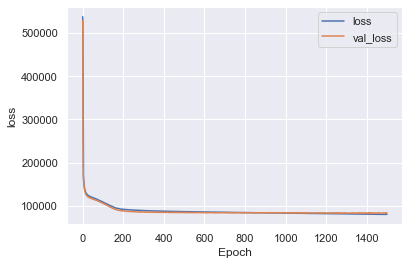

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.3, 1])
plt.legend(loc='upper right')
# test_loss, test_acc = net_final.evaluate([X_test],Y_test, verbose=2)
print('loss=',history.history['loss'][-1],"   ","val_loss=",history.history['val_loss'][-1])

In [17]:
predict_DNN_train = HW01.predict(x_train, verbose=1)
predict_DNN_val = HW01.predict(x_val, verbose=1)

68/68 [==============================] - 0s 995us/step


In [18]:
# KNN
def euclideanDistance(instance1,instance2,length):
    distance=0
    for x in range(length):
        distance += pow((instance1[x]-instance2[x]),2)
    return math.sqrt(distance)

def getNeighbors(trainingSet,testInstance,k):
    distances=[]
    length=len(testInstance)-1
    for x in range(len(trainingSet)):
        dist=euclideanDistance(testInstance,trainingSet[x],length)
        distances.append((trainingSet[x],dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors=[]
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def getLoss(testSet,predictions):
    loss=0
    for x in range(len(testSet)):
        loss = loss + abs(testSet[x][-1] - predictions[x])
    return loss/float(len(testSet))

In [19]:
import math
import operator

train = pd.read_csv("train-v3.csv")
val = pd.read_csv("valid-v3.csv")
train.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
val.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
x_train = train.drop('price', axis='columns')
y_train =train['price']
x_val = val.drop('price', axis='columns')
y_val = val['price']
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

KNN_train_data = np.empty((x_train.shape[0],x_train.shape[1] + 1))
for i in range(x_train.shape[0]):
    KNN_train_data[i] = np.hstack((x_train[i],y_train[i]))
    
KNN_val_data = np.empty((x_val.shape[0],x_val.shape[1] + 1))
for i in range(x_val.shape[0]):
    KNN_val_data[i] = np.hstack((x_val[i],y_val[i]))
    
trainingSet = KNN_train_data.tolist()  
testSet = KNN_val_data.tolist()

predict_KNN_val=[]
k = 13
for x in range(len(testSet)):
    neighbors=getNeighbors(trainingSet,testSet[x],k)
    result = sum([neighbors[i][-1] for i in range(k)]) / k
    predict_KNN_val.append(result)
loss = getLoss(testSet,predict_KNN_val)
print('for k=',k,' ','loss:',loss,sep = '')

for k=13 loss:85526.24710782041


In [20]:
predict_KNN_train=[]
k = 13
for x in range(len(trainingSet)):
    neighbors=getNeighbors(trainingSet,trainingSet[x],k)
    result = sum([neighbors[i][-1] for i in range(k)]) / k
    predict_KNN_train.append(result)
loss = getLoss(testSet,predict_KNN_train)
print('for k=',k,' ','loss:',loss,sep = '')

for k=13 loss:296395.0063716936


In [21]:
train = pd.read_csv("train-v3.csv")
val = pd.read_csv("valid-v3.csv")
train.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
val.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
x_train = train.drop('price', axis='columns')
y_train =train['price']
x_val = val.drop('price', axis='columns')
y_val = val['price']

In [22]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

In [23]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [24]:
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=50)

C:\Users\USER\anaconda3\envs\rtx3070\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\USER\anaconda3\envs\rtx3070\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's l1: 213992	valid_0's l2: 1.08796e+11
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l1: 205520	valid_0's l2: 1.01021e+11
[3]	valid_0's l1: 197811	valid_0's l2: 9.38813e+10
[4]	valid_0's l1: 190433	valid_0's l2: 8.73306e+10
[5]	valid_0's l1: 183511	valid_0's l2: 8.14114e+10
[6]	valid_0's l1: 177005	valid_0's l2: 7.599e+10
[7]	valid_0's l1: 170854	valid_0's l2: 7.11306e+10
[8]	valid_0's l1: 165852	valid_0's l2: 6.68758e+10
[9]	valid_0's l1: 160301	valid_0's l2: 6.2763e+10
[10]	valid_0's l1: 155129	valid_0's l2: 5.90199e+10
[11]	valid_0's l1: 149930	valid_0's l2: 5.54517e+10
[12]	valid_0's l1: 145145	valid_0's l2: 5.19771e+10
[13]	valid_0's l1: 141576	valid_0's l2: 4.9222e+10
[14]	valid_0's l1: 137386	valid_0's l2: 4.64032e+10
[15]	valid_0's l1: 133365	valid_0's l2: 4.36533e+10
[16]	va

[205]	valid_0's l1: 62817.7	valid_0's l2: 1.04772e+10
[206]	valid_0's l1: 62789.8	valid_0's l2: 1.04586e+10
[207]	valid_0's l1: 62751.1	valid_0's l2: 1.04473e+10
[208]	valid_0's l1: 62710.1	valid_0's l2: 1.04259e+10
[209]	valid_0's l1: 62637.9	valid_0's l2: 1.03938e+10
[210]	valid_0's l1: 62608.2	valid_0's l2: 1.03823e+10
[211]	valid_0's l1: 62571.2	valid_0's l2: 1.03775e+10
[212]	valid_0's l1: 62568.7	valid_0's l2: 1.03849e+10
[213]	valid_0's l1: 62548.2	valid_0's l2: 1.03904e+10
[214]	valid_0's l1: 62541.4	valid_0's l2: 1.03881e+10
[215]	valid_0's l1: 62553.5	valid_0's l2: 1.04e+10
[216]	valid_0's l1: 62537.1	valid_0's l2: 1.0391e+10
[217]	valid_0's l1: 62525.9	valid_0's l2: 1.03837e+10
[218]	valid_0's l1: 62509.4	valid_0's l2: 1.03677e+10
[219]	valid_0's l1: 62511.7	valid_0's l2: 1.03675e+10
[220]	valid_0's l1: 62525.5	valid_0's l2: 1.03827e+10
[221]	valid_0's l1: 62504.8	valid_0's l2: 1.03695e+10
[222]	valid_0's l1: 62469	valid_0's l2: 1.03579e+10
[223]	valid_0's l1: 62476.5	valid_

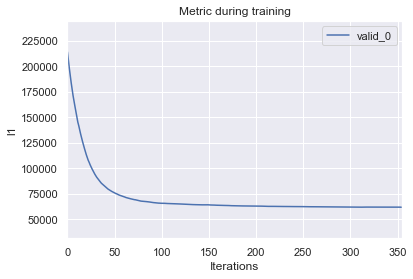

In [25]:
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

In [26]:
predict_lgb_train = gbm.predict(x_train)
predict_lgb_val = gbm.predict(x_val)

In [27]:
predict_lgb_train = predict_lgb_train.reshape(predict_lgb_train.shape[0],1)
predict_lgb_val = predict_lgb_val.reshape(predict_lgb_val.shape[0],1)
predict_lgb_train

array([[252030.67587184],
       [666855.44306425],
       [274202.24369279],
       ...,
       [283323.69810827],
       [426442.52714882],
       [523733.6121028 ]])

In [28]:
predict_KNN_train = np.array(predict_KNN_train).reshape(len(predict_KNN_train),1)
predict_KNN_val = np.array(predict_KNN_val).reshape(len(predict_KNN_val),1)
predict_KNN_train

array([[278876.92307692],
       [667153.84615385],
       [264303.84615385],
       ...,
       [330471.53846154],
       [440246.15384615],
       [601576.92307692]])

In [29]:
predict_DNN_train
predict_DNN_val

array([[ 899498.4 ],
       [1947297.9 ],
       [ 610553.1 ],
       ...,
       [ 351129.03],
       [ 324809.9 ],
       [ 800202.7 ]], dtype=float32)

In [30]:
predict_traindata_combine = np.hstack((predict_DNN_train,predict_KNN_train,predict_lgb_train))
predict_valdata_combine = np.hstack((predict_DNN_val,predict_KNN_val,predict_lgb_val))
predict_traindata_combine

array([[262784.0625    , 278876.92307692, 252030.67587184],
       [873675.        , 667153.84615385, 666855.44306425],
       [275067.375     , 264303.84615385, 274202.24369279],
       ...,
       [275458.15625   , 330471.53846154, 283323.69810827],
       [380104.96875   , 440246.15384615, 426442.52714882],
       [554536.125     , 601576.92307692, 523733.6121028 ]])

In [31]:
# 建構模型
inputs = Input(shape=(predict_traindata_combine.shape[1],), name='inputs')
layer1 = layers.Dense(8, activation='relu')(inputs)
# layer1 = layers.Dropout(0.1)(layer1)

layer2 = layers.Dense(32, activation='relu')(layer1)
# layer2 = layers.Dropout(0.2)(layer2)

layer3 = layers.Dense(8, activation='relu')(layer2)
# layer3 = layers.Dropout(0.1)(layer3)

outputs = layers.Dense(1, activation='linear')(layer3)
HW01_com = keras.Model(inputs, outputs)
HW01_com.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 查看模型
HW01_com.compile(optimizer=optimizers.Adam(lr=0.0001),
                  loss='mean_absolute_error',
               metrics=['mae'])
history_com = HW01_com.fit(predict_traindata_combine, y_train, 
               batch_size=64,  
               epochs=20,  
               validation_data=(predict_valdata_combine, y_val))

Epoch 1/20
203/203 [==============================] - 1s 3ms/step - loss: 494455.7796 - mae: 494455.7796 - val_loss: 391994.0000 - val_mae: 391994.0000
Epoch 2/20
203/203 [==============================] - 1s 3ms/step - loss: 356629.0945 - mae: 356629.0945 - val_loss: 224221.5938 - val_mae: 224221.5938
Epoch 3/20
203/203 [==============================] - 1s 2ms/step - loss: 175619.9278 - mae: 175619.9278 - val_loss: 67171.1250 - val_mae: 67171.1250
Epoch 4/20
203/203 [==============================] - 1s 3ms/step - loss: 61210.6748 - mae: 61210.6748 - val_loss: 65007.7422 - val_mae: 65007.7422
Epoch 5/20
203/203 [==============================] - 1s 2ms/step - loss: 58239.6745 - mae: 58239.6745 - val_loss: 63501.7031 - val_mae: 63501.7031
Epoch 6/20
203/203 [==============================] - 1s 2ms/step - loss: 56173.8166 - mae: 56173.8166 - val_loss: 62497.9922 - val_mae: 62497.9922
Epoch 7/20
203/203 [==============================] - 0s 2ms/step - loss: 54611.3141 - mae: 54611.3141

loss= 49721.25     val_loss= 61891.5078125


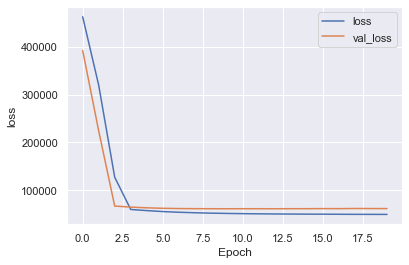

In [33]:
plt.plot(history_com.history['loss'], label='loss')
plt.plot(history_com.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.3, 1])
plt.legend(loc='upper right')
# test_loss, test_acc = net_final.evaluate([X_test],Y_test, verbose=2)
print('loss=',history_com.history['loss'][-1],"   ","val_loss=",history_com.history['val_loss'][-1])

In [34]:
train = pd.read_csv("train-v3.csv")
train.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
train = train.drop(del_cols, axis='columns')
x_train = train.drop('price', axis='columns')
mean1 = x_train.mean()
std1 = x_train.std()

In [35]:
# 導入測試資料
test = pd.read_csv("test-v3.csv")
test.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
predict_lgb_test = gbm.predict(test)
test = test.drop(del_cols, axis='columns')
test = (test - mean1) / std1
test = np.array(test)
test

array([[ 0.67750759, -0.46526463,  0.31402982, ...,  1.79344291,
         0.63024329, -0.40982302],
       [-0.38505179,  0.84144675,  1.56490655, ..., -0.65696674,
        -1.33409294,  1.44806379],
       [-1.44761116, -1.44529817, -1.1435135 , ..., -0.65696674,
         0.85761701, -0.73166168],
       ...,
       [-0.38505179, -1.44529817, -1.18702225, ..., -0.65696674,
         1.22673953, -1.33145191],
       [-1.44761116, -1.44529817,  0.17262637, ..., -0.65696674,
         1.28286342, -0.16112951],
       [-0.38505179, -1.44529817, -1.15439069, ..., -0.65696674,
        -1.68738565, -1.09738743]])

In [36]:
predict_DNN_test = HW01.predict(test, verbose=1)

203/203 [==============================] - 0s 859us/step


In [37]:
train = pd.read_csv("train-v3.csv")
train.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
x_train = train.drop('price', axis='columns')
mean = x_train.mean()
std = x_train.std()
test = pd.read_csv("test-v3.csv")
test.drop(['id','sale_yr','sale_month','sale_day'], axis="columns", inplace=True)
test = (test - mean) / std
test = np.array(test)

testSet = test.tolist()

predict_KNN_test=[]
k = 13
for x in range(len(testSet)):
    neighbors=getNeighbors(trainingSet,testSet[x],k)
    result = sum([neighbors[i][-1] for i in range(k)]) / k
    predict_KNN_test.append(result)

In [38]:
predict_lgb_test = predict_lgb_test.reshape(predict_lgb_test.shape[0],1)
predict_KNN_test = np.array(predict_KNN_test).reshape(len(predict_KNN_test),1)

In [39]:
predict_testdata_combine = np.hstack((predict_DNN_test,predict_KNN_test,predict_lgb_test))
predict_testdata_combine

array([[674392.375     , 529130.46153846, 695973.07861486],
       [626763.5       , 694038.46153846, 646904.51861797],
       [462929.96875   , 524192.30769231, 491744.13246106],
       ...,
       [307074.71875   , 331842.30769231, 339754.83727574],
       [459944.5       , 528880.76923077, 392177.47867037],
       [191717.0625    , 205338.46153846, 214387.92491155]])

In [40]:
predict_com = HW01_com.predict(predict_testdata_combine, verbose=1)

203/203 [==============================] - 0s 669us/step


In [41]:
predict = [predict_com[i][0] for i in range(predict_com.shape[0])]
predict

[699836.8,
 637983.7,
 485336.34,
 340596.38,
 901578.94,
 435904.12,
 187291.08,
 358219.1,
 314251.16,
 547166.25,
 1015864.44,
 336058.97,
 2058184.1,
 544066.8,
 523894.7,
 1316482.4,
 523003.47,
 420501.7,
 511038.84,
 429353.34,
 515164.6,
 1325154.0,
 550207.44,
 694236.25,
 322397.1,
 203885.36,
 664512.75,
 227691.03,
 566491.56,
 180239.5,
 831656.8,
 800076.75,
 413108.72,
 160276.3,
 234033.08,
 216701.89,
 254576.77,
 599589.06,
 632764.25,
 757795.1,
 589245.6,
 499672.22,
 840766.5,
 204495.5,
 229032.92,
 570900.06,
 373610.56,
 812417.8,
 1046531.94,
 2576292.8,
 382536.75,
 814885.4,
 733447.8,
 355001.75,
 533966.5,
 462984.62,
 566366.2,
 546363.1,
 274175.4,
 237613.17,
 239733.45,
 260807.12,
 360834.72,
 816196.3,
 282346.2,
 433393.84,
 837279.2,
 299093.6,
 818117.7,
 595434.7,
 451484.75,
 430073.97,
 636823.2,
 919602.94,
 467624.62,
 2574862.5,
 262610.72,
 619433.2,
 541245.8,
 1877634.9,
 234986.56,
 431301.06,
 425182.47,
 800477.2,
 369103.84,
 482634.8,

In [42]:
with open('sampleSubmission.csv','w') as output:
    output.write('id,price\n')
    for i in range(len(predict)):
        output.write(str(i+1) + "," + str(predict[i]) + '\n')